# Operational Space Control

### Start Meshcat Visualizer
Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://c140ec4a-6224-46c8-b55a-d8a7a25ad3a5.deepnoteproject.com/7001/


### Setup the simulation

Drake simulations are built as block diagrams, similarly to Simulink or LabVIEW, except the blocks (systems) are defined programatically rather than graphically. 

This cell creates a Drake Diagram, and adds the system blocks for the OSC, footstep planner, and a simulated planar walker. You can change the OSC gains and the desired walking speed, then run this cell to view the diagram it creates. The next cell runs the simulation, which you can view in meshcat.

/shared-libs/python3.8/py/lib/python3.8/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.17.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
InputPortIndex(1)


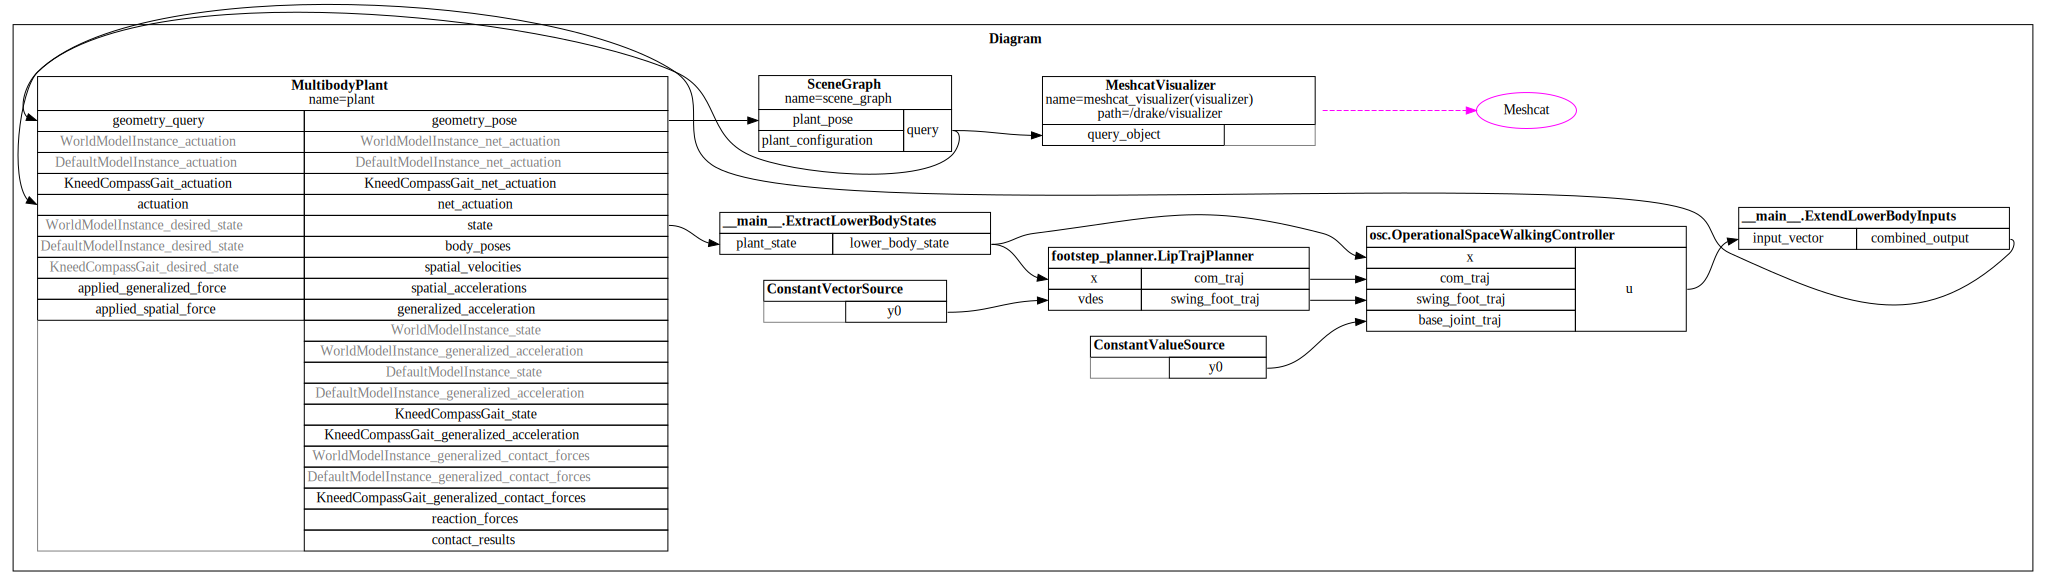

In [2]:
import pydot
import numpy as np
from IPython.display import SVG, display

from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction, LeafSystem, BasicVector
import footstep_planner
import osc
import importlib
importlib.reload(osc)
importlib.reload(footstep_planner)
from osc import OperationalSpaceWalkingController, OscGains

# Build the block diagram for the simulation
builder = DiagramBuilder()

# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", 
    CoulombFriction(1.0, 1.0)
)
parser = Parser(plant)
 
# parser.AddModels("humanoid_walker.urdf") # humanoid with 2 arms
parser.AddModels("humanoid_walker.urdf") # humanoid with 2 arms fixed
# parser.AddModels("planar_walker.urdf") # only lower body

plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()


# Build the controller diagram
Kp = np.diag([100, 0, 100])
Kd = np.diag([10, 0, 10])
W = np.diag([1, 0, 1])

Wcom = np.zeros((3,3))
Wcom[2,2] = 1

# gains for humanoid with arms fixed
gains = OscGains(
        Kp, Kd, Wcom,
        Kp, Kd, W,
        60 * np.eye(1), 6 * np.eye(1), np.eye(1),
        0.00001
    )

walking_speed = 0.2 # walking speed in m/s for humanoid with arms fixed

osc = builder.AddSystem(OperationalSpaceWalkingController(gains))
planner = builder.AddSystem(footstep_planner.LipTrajPlanner())

#################################################################################
speed_src = builder.AddSystem(ConstantVectorSource(np.array([walking_speed])))

# class SpeedSource(LeafSystem):
#     def __init__(self, walking_speed):
#         super().__init__()
#         self.walking_speed = walking_speed

#         # Declare an input port for the states to check distance walked (x value)
#         self.DeclareVectorInputPort("states", BasicVector(22))

#         # Declare an output port for the desired speed
#         # self.DeclareVectorOutputPort("desired_speed", BasicVector(1), self.WalkForTime)
#         self.DeclareVectorOutputPort("desired_speed", BasicVector(1), self.WalkForDistance)

#     def WalkForTime(self, context, output):
#         t = context.get_time()

#         if t < 3.0: # walk for 3 seconds
#             output.SetFromVector([self.walking_speed])
#         else:
#             output.SetFromVector([0.1]) 
#             # making speed 0.1 m/s so it barely walks (making it 0 will make it actually move slightly backward)

#     def WalkForDistance(self, context, output):
#         x = self.get_input_port(0).Eval(context)[0]

#         if x < 0.5: # walk for 0.5 meters
#             output.SetFromVector([self.walking_speed])
#         else:
#             output.SetFromVector([0.1]) 

# speed_src = builder.AddSystem(SpeedSource(walking_speed))
# builder.Connect(plant.get_state_output_port(), 
#                 speed_src.get_input_port())

#################################################################################
base_traj_src = builder.AddSystem(
    ConstantValueSource(AbstractValue.Make(PiecewisePolynomial(np.zeros(1,))))
)

############################################################################
class ExtractLowerBodyStates(LeafSystem):
    def __init__(self):
        super().__init__()
        
        # Declare an input port for the full plant state (22 states)
        input_port = self.DeclareVectorInputPort("plant_state", BasicVector(22))
        
        # Declare an output port for the actuated states 
        self.DeclareVectorOutputPort(
            "lower_body_state", BasicVector(14),  # 14 states in total
            lambda context, output: output.SetFromVector(
                np.hstack([
                    self.get_input_port(0).Eval(context)[:3],         # 1st to 3rd states
                    self.get_input_port(0).Eval(context)[7:14],       # 8th to 14th states
                    self.get_input_port(0).Eval(context)[18:22]      # 19th to 22nd states
                ])
            )
        )

lower_body_system = ExtractLowerBodyStates()
builder.AddSystem(lower_body_system)

# wire plant state to lower body system
builder.Connect(plant.get_state_output_port(), 
                lower_body_system.get_input_port(0))

# Wire planner inputs 
# builder.Connect(plant.get_state_output_port(), 
#                 planner.get_state_input_port())
builder.Connect(lower_body_system.get_output_port(0), 
                planner.get_state_input_port())
builder.Connect(speed_src.get_output_port(), 
                planner.get_walking_speed_input_port())

# Wire OSC inputs
# builder.Connect(plant.get_state_output_port(), 
#                 osc.get_state_input_port()) 
builder.Connect(lower_body_system.get_output_port(0),
                osc.get_state_input_port()) 
builder.Connect(planner.get_swing_foot_traj_output_port(), 
                osc.get_traj_input_port("swing_foot_traj"))
builder.Connect(planner.get_com_traj_output_port(), 
                osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), 
                osc.get_traj_input_port("base_joint_traj"))

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.01)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

##########################################################################################
# Wire OSC to plant
# builder.Connect(osc.get_output_port(), 
#                 plant.get_actuation_input_port())

class ExtendLowerBodyInputs(LeafSystem):
    def __init__(self):
        super().__init__()
        
        # Declare a single input port that takes a 4-dimensional vector
        self.DeclareVectorInputPort("input_vector", BasicVector(4))
        
        # Declare an output port with 8 elements
        self.DeclareVectorOutputPort(
            "combined_output", BasicVector(8),
            lambda context, output: output.SetFromVector(
                np.hstack([self.get_input_port().Eval(context), np.zeros(4)])
            )
        )

full_body_input = ExtendLowerBodyInputs()
builder.AddSystem(full_body_input)

builder.Connect(osc.get_output_port(), 
                full_body_input.get_input_port(0))
builder.Connect(full_body_input.get_output_port(0), 
                plant.get_actuation_input_port())
##########################################################################################

#simulate
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

Walk for certain time / distance and then stop and walk in place

InputPortIndex(1)


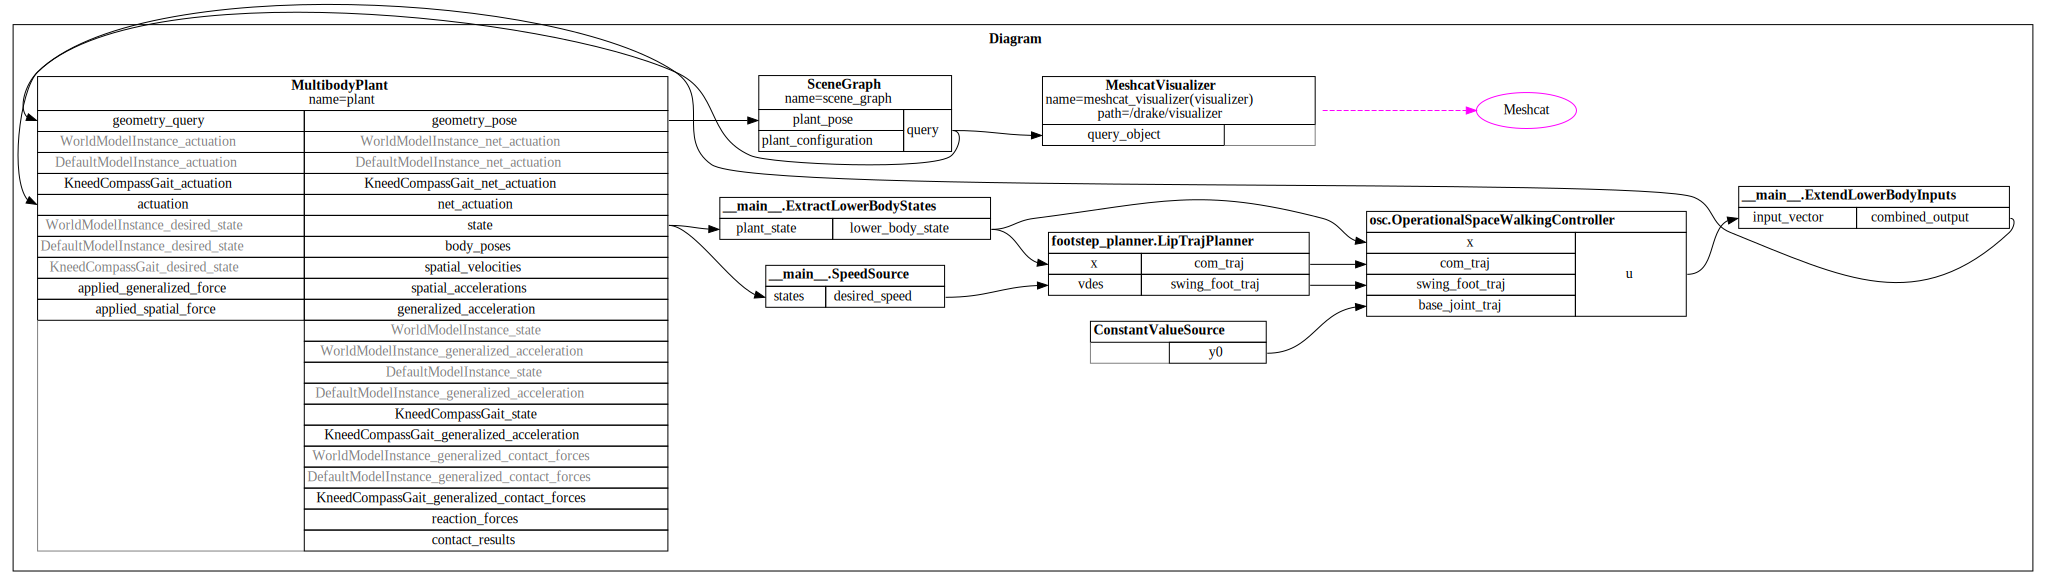

In [3]:
import pydot
import numpy as np
from IPython.display import SVG, display

from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction, LeafSystem, BasicVector
import footstep_planner
import osc
import importlib
importlib.reload(osc)
importlib.reload(footstep_planner)
from osc import OperationalSpaceWalkingController, OscGains

# Build the block diagram for the simulation
builder = DiagramBuilder()

# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", 
    CoulombFriction(1.0, 1.0)
)
parser = Parser(plant)
 
# parser.AddModels("humanoid_walker.urdf") # humanoid with 2 arms
parser.AddModels("humanoid_walker.urdf") # humanoid with 2 arms fixed
# parser.AddModels("planar_walker.urdf") # only lower body

plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()


# Build the controller diagram
Kp = np.diag([100, 0, 100])
Kd = np.diag([10, 0, 10])
W = np.diag([1, 0, 1])

Wcom = np.zeros((3,3))
Wcom[2,2] = 1

# gains for humanoid with arms fixed
gains = OscGains(
        Kp, Kd, Wcom,
        Kp, Kd, W,
        60 * np.eye(1), 6 * np.eye(1), np.eye(1),
        0.00001
    )

walking_speed = 0.2 # walking speed in m/s for humanoid with arms fixed

osc = builder.AddSystem(OperationalSpaceWalkingController(gains))
planner = builder.AddSystem(footstep_planner.LipTrajPlanner())

#################################################################################
# speed_src = builder.AddSystem(ConstantVectorSource(np.array([walking_speed])))

class SpeedSource(LeafSystem):
    def __init__(self, walking_speed):
        super().__init__()
        self.walking_speed = walking_speed

        # Declare an input port for the states to check distance walked (x value)
        self.DeclareVectorInputPort("states", BasicVector(22))

        # Declare an output port for the desired speed
        # self.DeclareVectorOutputPort("desired_speed", BasicVector(1), self.WalkForTime)
        self.DeclareVectorOutputPort("desired_speed", BasicVector(1), self.WalkForDistance)

    def WalkForTime(self, context, output):
        t = context.get_time()

        if t < 3.0: # walk for 3 seconds
            output.SetFromVector([self.walking_speed])
        else:
            output.SetFromVector([0.1]) 
            # making speed 0.1 m/s so it barely walks (making it 0 will make it actually move slightly backward)

    def WalkForDistance(self, context, output):
        x = self.get_input_port(0).Eval(context)[0]

        if x < 0.5: # walk for 0.5 meters
            output.SetFromVector([self.walking_speed])
        else:
            output.SetFromVector([0.1]) 

speed_src = builder.AddSystem(SpeedSource(walking_speed))
builder.Connect(plant.get_state_output_port(), 
                speed_src.get_input_port(0))

#################################################################################
base_traj_src = builder.AddSystem(
    ConstantValueSource(AbstractValue.Make(PiecewisePolynomial(np.zeros(1,))))
)

############################################################################
class ExtractLowerBodyStates(LeafSystem):
    def __init__(self):
        super().__init__()
        
        # Declare an input port for the full plant state (22 states)
        input_port = self.DeclareVectorInputPort("plant_state", BasicVector(22))
        
        # Declare an output port for the actuated states 
        self.DeclareVectorOutputPort(
            "lower_body_state", BasicVector(14),  # 14 states in total
            lambda context, output: output.SetFromVector(
                np.hstack([
                    self.get_input_port(0).Eval(context)[:3],         # 1st to 3rd states
                    self.get_input_port(0).Eval(context)[7:14],       # 8th to 14th states
                    self.get_input_port(0).Eval(context)[18:22]      # 19th to 22nd states
                ])
            )
        )

lower_body_system = ExtractLowerBodyStates()
builder.AddSystem(lower_body_system)

# wire plant state to lower body system
builder.Connect(plant.get_state_output_port(), 
                lower_body_system.get_input_port(0))

# Wire planner inputs 
# builder.Connect(plant.get_state_output_port(), 
#                 planner.get_state_input_port())
builder.Connect(lower_body_system.get_output_port(0), 
                planner.get_state_input_port())
builder.Connect(speed_src.get_output_port(), 
                planner.get_walking_speed_input_port())

# Wire OSC inputs
# builder.Connect(plant.get_state_output_port(), 
#                 osc.get_state_input_port()) 
builder.Connect(lower_body_system.get_output_port(0),
                osc.get_state_input_port()) 
builder.Connect(planner.get_swing_foot_traj_output_port(), 
                osc.get_traj_input_port("swing_foot_traj"))
builder.Connect(planner.get_com_traj_output_port(), 
                osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), 
                osc.get_traj_input_port("base_joint_traj"))

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.01)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

##########################################################################################
# Wire OSC to plant
# builder.Connect(osc.get_output_port(), 
#                 plant.get_actuation_input_port())

class ExtendLowerBodyInputs(LeafSystem):
    def __init__(self):
        super().__init__()
        
        # Declare a single input port that takes a 4-dimensional vector
        self.DeclareVectorInputPort("input_vector", BasicVector(4))
        
        # Declare an output port with 8 elements
        self.DeclareVectorOutputPort(
            "combined_output", BasicVector(8),
            lambda context, output: output.SetFromVector(
                np.hstack([self.get_input_port().Eval(context), np.zeros(4)])
            )
        )

full_body_input = ExtendLowerBodyInputs()
builder.AddSystem(full_body_input)

builder.Connect(osc.get_output_port(), 
                full_body_input.get_input_port(0))
builder.Connect(full_body_input.get_output_port(0), 
                plant.get_actuation_input_port())
##########################################################################################

#simulate
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

### Run the simulation
After you have run the above block, you can actually run the simulation with this one.

In [4]:
# NOTE - if you make changes, you should re-run the cell above this one

sim_time = 3.0
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)

# Set the robot state
plant_context = diagram.GetMutableSubsystemContext(
    plant, simulator.get_mutable_context())
q = np.zeros((plant.num_positions(),))
q[1] = 0.8
theta = -np.arccos(q[1])
q[7] = theta
q[8] = -2 * theta
q[9] = theta
q[10] = -2 * theta
plant.SetPositions(plant_context, q)

# Start recording the animation
meshcat.StartRecording()
simulator.AdvanceTo(sim_time)
meshcat.StopRecording()
meshcat.PublishRecording()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c140ec4a-6224-46c8-b55a-d8a7a25ad3a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>